In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
from scipy.stats import gaussian_kde
import numpy.ma as ma
import math

In [2]:
dem=xr.open_dataset('/g/data/dt55/wil_outputs/dem_aus.nc')#,parallel=True,lock=False)
source_ds=dem.rename_vars({'ASCIITo_asc1':'dem'})

In [3]:
## Some useful functions
# Make a Cartopy Projection Object from netcdf Proj info
def get_ccrs_from_proj(ds):
    import cartopy.crs as ccrs
    if 'proj' in ds.variables:
        try:
            return ccrs.AlbersEqualArea(central_longitude=ds.proj.attrs['longitude_of_central_meridian'],
                            central_latitude=ds.proj.attrs['latitude_of_projection_origin'],
                            false_easting=ds.proj.attrs['false_easting'],
                            false_northing=ds.proj.attrs['false_northing'],
                            standard_parallels=ds.proj.attrs['standard_parallel'],
                            globe=None)
        except Exception as err:
            print(err)
            return ccrs.PlateCarree()


# define color table for RF3
class cmap_rf3(object):
    """Define color maps for RF3 rainfall products."""

    from matplotlib.colors import ListedColormap
    import matplotlib.pyplot as plt

    # RAINFALL
    rainfall_colors = np.array([(255, 255, 255),  # 0.0
                                (245, 245, 255),  # 0.2
                                (180, 180, 255),  # 0.5
                                (120, 120, 255),  # 1.5
                                (20,  20, 255),  # 2.5
                                (0, 216, 195),  # 4.0
                                (0, 150, 144),  # 6.0
                                (0, 102, 102),  # 10
                                (255, 255,   0),  # 15
                                (255, 200,   0),  # 20
                                (255, 150,   0),  # 30
                                (255, 100,   0),  # 40
                                (255,   0,   0),  # 50
                                (200,   0,   0),  # 60
                                (120,   0,   0),  # 75
                                (100,   0,   0)])  # > 100
    rainfall_colors = rainfall_colors/255.
    #cm_rainfall = 'blues'
    cm_rainfall = ListedColormap(rainfall_colors, 'blues')
    rainfall_levels = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]        
    rainfall_levels_hr = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]        
    rainfall_levels_10min = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]  
    rainfall_levels_m = [0,20,40,60,80,100,120,140,160,180,200,220,240,260]
        
def transform_coords_from_km_to_m(ds):
    """Transform coords from km to m (if required)."""
    if ds is not None:
        if 'x' in ds.coords:
            if 'units' in ds.x.attrs:
                if ds.x.units == 'km':
                    ds['x'] = ds.x*1000.
                    ds.x.attrs.update({'units': 'm'})
                    ds.x.attrs.update(
                        {'standard_name':
                         'projection_x_coordinate'})
                    message = '; Original coords x transformed to m from km'
                    if 'history' in ds.attrs:
                        ds.attrs['history'] += message
                    else:
                        ds.attrs['history'] = message
                if ds.y.units == 'km':
                    ds['y'] = ds.y*1000.
                    ds.y.attrs.update({'units': 'm'})
                    ds.y.attrs.update(
                        {'standard_name':
                         'projection_y_coordinate'})
                    ds.attrs['history'] += '; Original coords y transformed to m from km'
    return ds

def preprocess_radar(ds):
    ds = transform_coords_from_km_to_m(ds)
    if 'n2' in ds.dims:
        ds = ds.drop_dims('n2')
    return ds

def get_projection_from_dataset(rainfall):
    """Return a cartopy projection object from a dataset."""
    try:
        if ('proj' in rainfall.data_vars):
            proj = rainfall.variables['proj']
            if (proj.attrs['grid_mapping_name'] ==
                    "albers_conical_equal_area"):
                projection = ccrs.AlbersEqualArea(
                    central_longitude=proj.attrs['longitude_of_central_meridian'],
                    central_latitude=proj.attrs['latitude_of_projection_origin'],
                    standard_parallels=proj.attrs['standard_parallel'],
                    )
            elif (getattr(proj, 'grid_mapping_name') ==
                    "gnomonic"):
                print('Projection is gnomonic')
                projection = ccrs.Gnomonic(
                    central_longitude=proj.attrs['longitude_of_projection_origin'],
                    central_latitude=proj.attrs['latitude_of_projection_origin'],
                    )
        else:
            print("INFO: Assuming standard PlateCarree projection")
            projection = ccrs.PlateCarree()
        return projection
    except Exception as err:
        print(err)
        return None

def get_coords_from_dataset(rainfall):
    """Return coordinates in a dataset."""
    try:
        if ('lat' in rainfall.coords):
            x = rainfall['lon'][:].data
            y = rainfall['lat'][:].data
        elif ('x' in rainfall.coords):
            x = rainfall['x'][:].data
            y = rainfall['y'][:].data
            if (rainfall['x'].units == 'km'):
                factor = 1000.
                x = x * factor
                y = y * factor
        else:
            x = np.array(None)
            y = np.array(None)
        return x, y
    except Exception as err:
        print(err)
        return None, None

In [4]:
victas_tile='/g/data/dt55/pst/projection/PST_tile_T22-Vic-TAS_projection.nc'
victas_tile_ds=xr.open_dataset(victas_tile)

perth_tile='/g/data/dt55/pst/projection/PST_tile_T16-Perth_projection.nc'
perth_tile_ds=xr.open_dataset(perth_tile)

## Non hourly data

In [5]:
# VICTAS
# mean
victas_mean=xr.open_dataset("/home/565/dm2042/WIL/Scatter-plot-data/victas_mean.nc")
# std
victas_std=xr.open_dataset("/home/565/dm2042/WIL/Scatter-plot-data/victas_std.nc")

In [6]:
# PERTH
# mean
perth_mean=xr.open_dataset("/home/565/dm2042/WIL/Scatter-plot-data/perth_mean.nc")
# std
perth_std=xr.open_dataset("/home/565/dm2042/WIL/Scatter-plot-data/perth_std.nc")

In [7]:
victas_count_full=xr.open_dataset("/home/565/dm2042/WIL/Frequency-data/victas_count.nc")

In [8]:
# hour_times = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']

In [9]:
# range(len(hour_times))

## Hourly count data

### VicTas

In [10]:
my_hourly_files="/home/565/dm2042/WIL/Frequency-data/victas_count-hour*.nc"
my_hourly_count_ds=xr.open_mfdataset(
    my_hourly_files,
    combine='nested',
    concat_dim='hour',
    parallel=True,
    lock=False,
    ).sortby('hour')
my_hourly_count_ds

<xarray.Dataset>
Dimensions:        (hour: 24, x: 512, y: 512)
Coordinates:
  * y              (y) float64 -4.911e+06 -4.909e+06 ... -3.891e+06 -3.889e+06
  * x              (x) float64 6.89e+05 6.91e+05 ... 1.709e+06 1.711e+06
  * hour           (hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Data variables:
    precipitation  (hour, y, x) int64 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

### Perth

In [11]:
my_hourly_files_p="/home/565/dm2042/WIL/Frequency-data/perth_count-hour*.nc"
my_hourly_count_ds_p=xr.open_mfdataset(
    my_hourly_files_p,
    combine='nested',
    concat_dim='hour',
    parallel=True,
    lock=False,
    ).sortby('hour')
my_hourly_count_ds_p

<xarray.Dataset>
Dimensions:        (hour: 24, x: 512, y: 512)
Coordinates:
  * y              (y) float64 -4.211e+06 -4.209e+06 ... -3.191e+06 -3.189e+06
  * x              (x) float64 -2.011e+06 -2.009e+06 ... -9.91e+05 -9.89e+05
  * hour           (hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Data variables:
    precipitation  (hour, y, x) int64 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

## Hourly mean data

### VicTas

In [12]:
my_hourly_files="/home/565/dm2042/WIL/Mean-data/victas_mean-hour-*.nc"
my_hourly_mean_ds=xr.open_mfdataset(
    my_hourly_files,
    combine='nested',
    concat_dim='hour',
    parallel=True,
    lock=False,
    ).sortby('hour')
my_hourly_mean_ds

<xarray.Dataset>
Dimensions:        (hour: 24, x: 512, y: 512)
Coordinates:
  * y              (y) float64 -4.911e+06 -4.909e+06 ... -3.891e+06 -3.889e+06
  * x              (x) float64 6.89e+05 6.91e+05 ... 1.709e+06 1.711e+06
  * hour           (hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Data variables:
    precipitation  (hour, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

### Perth

In [13]:
my_hourly_files_p="/home/565/dm2042/WIL/Mean-data/perth_mean-hour-*.nc"
my_hourly_mean_ds_p=xr.open_mfdataset(
    my_hourly_files_p,
    combine='nested',
    concat_dim='hour',
    parallel=True,
    lock=False,
    ).sortby('hour')
my_hourly_mean_ds_p

<xarray.Dataset>
Dimensions:        (hour: 24, x: 512, y: 512)
Coordinates:
  * y              (y) float64 -4.211e+06 -4.209e+06 ... -3.191e+06 -3.189e+06
  * x              (x) float64 -2.011e+06 -2.009e+06 ... -9.91e+05 -9.89e+05
  * hour           (hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Data variables:
    precipitation  (hour, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

In [14]:
target_proj_v = get_projection_from_dataset(victas_tile_ds)
target_proj_p = get_projection_from_dataset(perth_tile_ds)

In [15]:
target_x_points_v, target_y_points_v = get_coords_from_dataset(victas_tile_ds)
coord_x_grid_target_v, coord_y_grid_target_v = np.meshgrid(target_x_points_v,
                                                           target_y_points_v)
proj_info_v = victas_tile_ds.proj.copy()

target_x_points_p, target_y_points_p = get_coords_from_dataset(perth_tile_ds)
coord_x_grid_target_p, coord_y_grid_target_p = np.meshgrid(target_x_points_p,
                                                           target_y_points_p)
proj_info_p = perth_tile_ds.proj.copy()

In [16]:
source_proj_p = get_projection_from_dataset(source_ds)
target_xyz = source_proj_p.transform_points(target_proj_p,
                                              coord_x_grid_target_p,
                                              coord_y_grid_target_p,
                                              )
# store new coordinates in the source projection
# as DataArray

new_y_v = xr.DataArray(target_xyz[:, :, 1],
                     dims=["y","x"],
                     coords={"x": target_x_points_p,"y":target_y_points_p})
new_x_v = xr.DataArray(target_xyz[:, :, 0],
                     dims=["y","x"],
                     coords={"x": target_x_points_p,"y":target_y_points_p})

INFO: Assuming standard PlateCarree projection


In [17]:
topo_v = source_ds['dem'].interp(lon=new_x_v,lat=new_y_v,method='nearest')

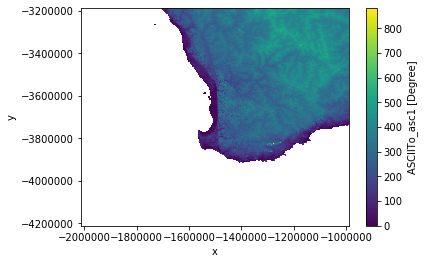

In [18]:
topo_v.plot()

In [19]:
full_hourly_mean_ds = my_hourly_mean_ds_p.assign(dem=topo_v.drop(['lat','lon']))
full_hourly_mean_ds

<xarray.Dataset>
Dimensions:        (hour: 24, x: 512, y: 512)
Coordinates:
  * y              (y) float64 -4.211e+06 -4.209e+06 ... -3.191e+06 -3.189e+06
  * x              (x) float64 -2.011e+06 -2.009e+06 ... -9.91e+05 -9.89e+05
  * hour           (hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Data variables:
    precipitation  (hour, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    dem            (y, x) float32 nan nan nan nan ... 370.1354 371.6743 374.2016

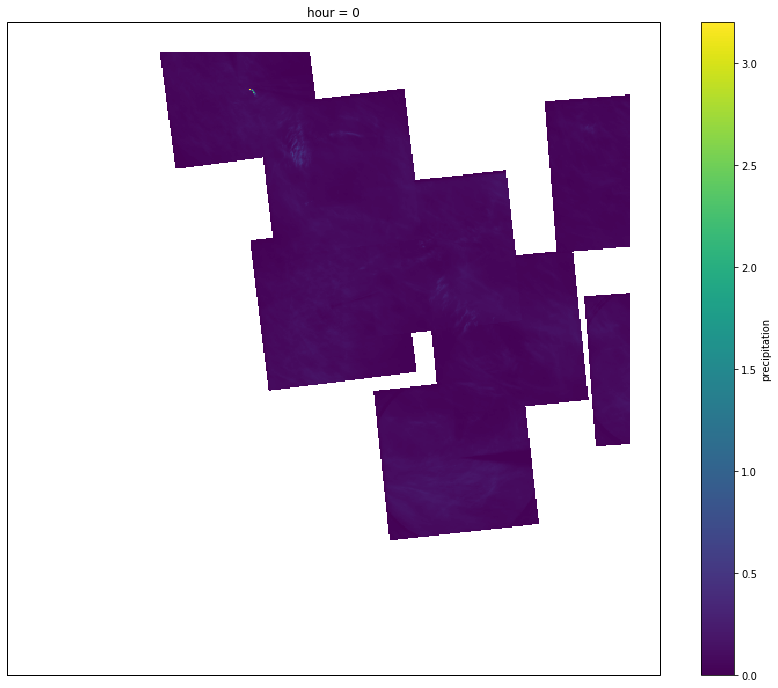

In [20]:
fig,ax=plt.subplots(figsize=(15,12),subplot_kw={'projection':target_proj_p})
full_hourly_mean_ds.sel(hour=0).precipitation.plot()

In [21]:
full_hourly_mean_ds.sum('hour')

<xarray.Dataset>
Dimensions:        (x: 512, y: 512)
Coordinates:
  * y              (y) float64 -4.211e+06 -4.209e+06 ... -3.191e+06 -3.189e+06
  * x              (x) float64 -2.011e+06 -2.009e+06 ... -9.91e+05 -9.89e+05
Data variables:
    precipitation  (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    dem            (y, x) float32 0.0 0.0 0.0 0.0 ... 370.1354 371.6743 374.2016

In [22]:
full_hourly_mean_ds.sel(hour=0)

<xarray.Dataset>
Dimensions:        (x: 512, y: 512)
Coordinates:
  * y              (y) float64 -4.211e+06 -4.209e+06 ... -3.191e+06 -3.189e+06
  * x              (x) float64 -2.011e+06 -2.009e+06 ... -9.91e+05 -9.89e+05
    hour           int64 0
Data variables:
    precipitation  (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    dem            (y, x) float32 nan nan nan nan ... 370.1354 371.6743 374.2016

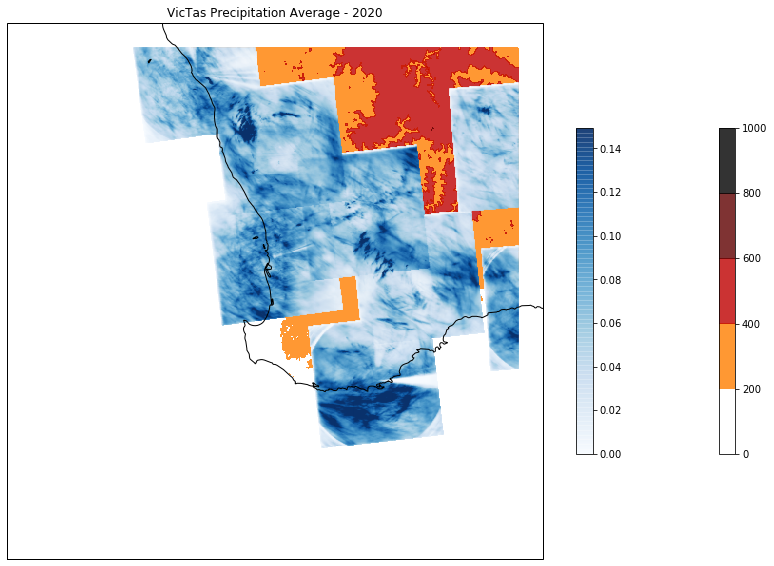

In [23]:
fig,ax=plt.subplots(figsize=(15,12),subplot_kw={'projection':target_proj_p})
dem_plot = full_hourly_mean_ds.sel(hour=0).dem.plot.contourf(levels=6,cmap='gist_heat_r',add_colorbar=False,ax=ax,add_labels=True,alpha=0.8)
precip_plot = full_hourly_mean_ds.sel(hour=0).precipitation.plot(ax=ax,add_colorbar=False,cmap='Blues',
            alpha=0.7,robust=True,vmin=0,)
plt.colorbar(dem_plot, shrink=0.5)
plt.colorbar(precip_plot, shrink=0.5)
ax.coastlines('10m')
ax.set_title('VicTas Precipitation Average - 2020')
plt.show()

In [24]:
sel_full_hourly_mean_ds = full_hourly_mean_ds.isel(x=slice(200,300),y=slice(380,480))
sel_hourly_count_ds = my_hourly_count_ds_p.isel(x=slice(200,300),y=slice(380,480))
sel_perth_mean = perth_mean.isel(x=slice(200,300),y=slice(380,480))
sel_perth_std = perth_std.isel(x=slice(200,300),y=slice(380,480))

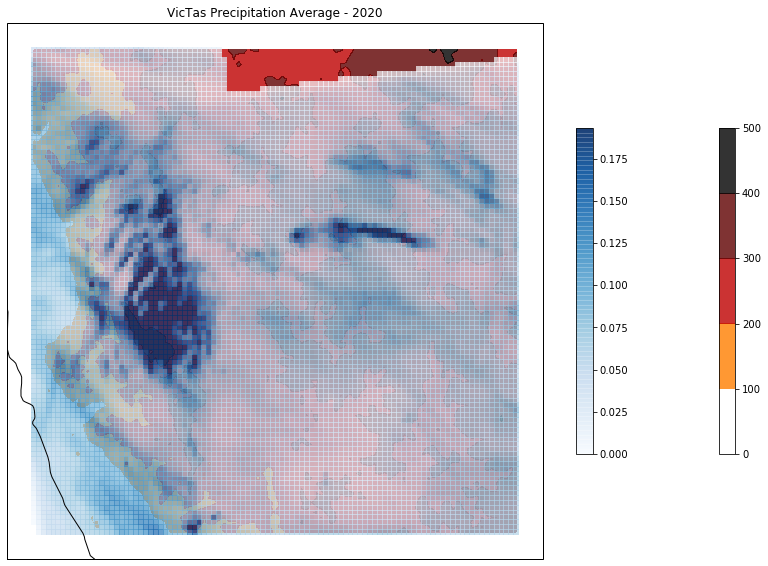

In [25]:
fig,ax=plt.subplots(figsize=(15,12),subplot_kw={'projection':target_proj_p})
dem_plot = sel_full_hourly_mean_ds.dem.plot.contourf(levels=6,cmap='gist_heat_r',add_colorbar=False,ax=ax,add_labels=True,alpha=0.8)
freq_plot = sel_full_hourly_mean_ds.sel(hour=0).precipitation.plot(ax=ax,add_colorbar=False,cmap='Blues',
            alpha=0.7,robust=True,vmin=0,)
plt.colorbar(dem_plot, shrink=0.5)
plt.colorbar(freq_plot, shrink=0.5)
ax.coastlines('10m')
ax.set_title('VicTas Precipitation Average - 2020')
plt.show()

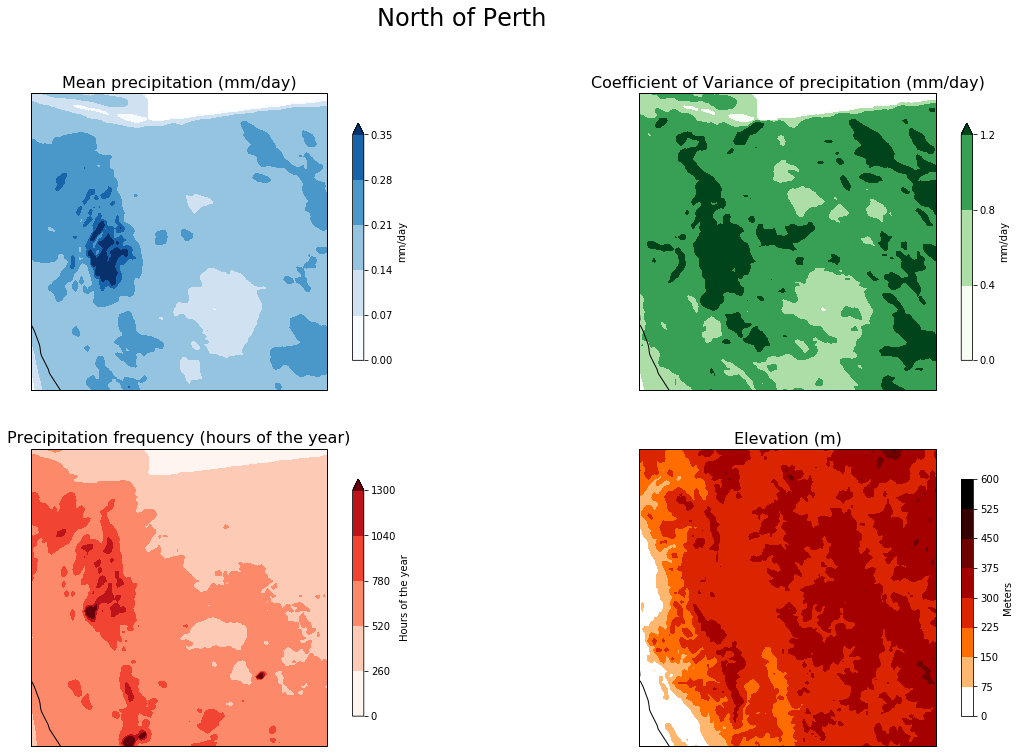

In [26]:
fig, axs=plt.subplots(2,2,figsize=(20,12),subplot_kw={'projection':target_proj_p})
precip_plot = sel_perth_mean.precipitation.plot.contourf(ax=axs[0,0],add_colorbar=False,cmap='Blues',
            robust=True,vmin=0,levels=6,vmax=0.35)
std_plot = sel_perth_std.precipitation.plot.contourf(ax=axs[0,1],add_colorbar=False,
                                                         cmap='Greens',
            levels=4,robust=True,vmin=0,vmax=1.2)
# ax2.clabel(std_plot, fmt="%2.1f", use_clabeltext=True, colors=['yellow','yellow','orange','red'])
dem_plot = sel_full_hourly_mean_ds.dem.plot.contourf(levels=9,cmap='gist_heat_r',add_colorbar=False,ax=axs[1,1],add_labels=True,vmax=600)#,alpha=0.8)
freq_plot = sel_hourly_count_ds.sum('hour').precipitation.plot.contourf(ax=axs[1,0],add_colorbar=False,cmap='Reds',
            levels=6,robust=True,vmin=0,vmax=1300)
plt.colorbar(dem_plot, shrink=0.8,ax=axs[1,1],label='Meters')
plt.colorbar(precip_plot, shrink=0.8,ax=axs[0,0],label='mm/day')
plt.colorbar(freq_plot, shrink=0.8,ax=axs[1,0],label='Hours of the year')
plt.colorbar(std_plot, shrink=0.8,ax=axs[0,1],label='mm/day')
axs[0,0].coastlines('10m')
axs[0,1].coastlines('10m')
axs[1,0].coastlines('10m')
axs[1,1].coastlines('10m')
fig.suptitle('North of Perth',fontsize=24)
axs[0,0].set_title('Mean precipitation (mm/day)',fontsize=16)
axs[0,1].set_title('Coefficient of Variance of precipitation (mm/day)',fontsize=16)
axs[1,0].set_title('Precipitation frequency (hours of the year)',fontsize=16)
axs[1,1].set_title('Elevation (m)',fontsize=16)
axs[0,0].xaxis.grid(True,color = "black")
axs[0,1].grid(True)
axs[1,0].grid(True)
axs[1,1].grid(True)
plt.show()

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


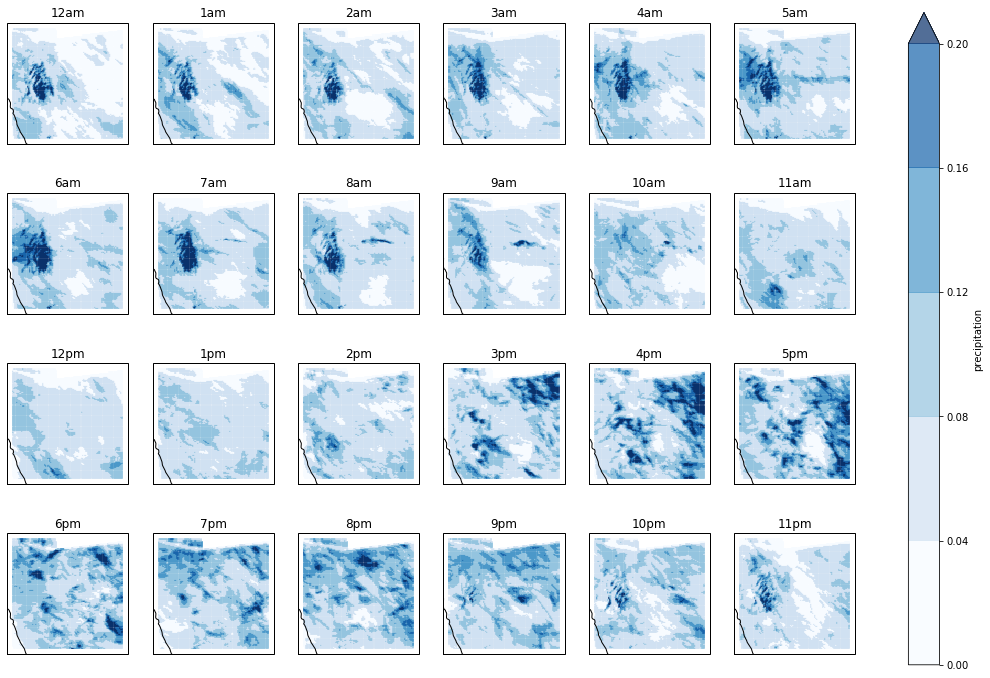

In [27]:
plt.close()
# Load the data
# ds = victas_month.precipitation
perth_hour_plot = sel_full_hourly_mean_ds.isel(hour=[16,17,18,19,20,21,22,23,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]).precipitation
# T15_month_plot = T15_month.isel(month=[0,2,5,7,9,11]).precipitation

# This is the map projection we want to plot onto
map_proj = target_proj_p

p = perth_hour_plot.plot(transform=map_proj,  # the data's projection
                        col='hour', col_wrap=6,  # multiplot settings
                        cmap='Blues',
                        levels=6,alpha=0.7,
                        subplot_kws={'projection': map_proj},
                          robust=True
#                         size=8,
                       )  # the plot's projection

#oro = new_output_ds.plot.contourf(levels=6,cmap='gist_heat_r',linewidths=0.9,add_colorbar=True,ax=ax,add_labels=True,alpha=0.7)

# We have to set the map's options on all four axes
i=0
my_titles=['12am','1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm']
for ax in p.axes.flat:
    ax.coastlines('10m')
#     sel_full_hourly_mean_ds.sel(hour=0).plot(levels=6,cmap='gist_heat_r',linewidths=0.9,add_colorbar=True,ax=ax,add_labels=True,alpha=0.7)
#     ax.set_extent([-160, -30, 5, 75])
#     ax.set_aspect('equal', 'box-forced')
    ax.set_title(my_titles[i])
    i=i+1
# plt.colorbar(p, label='Meters (mm/day)')
plt.show()

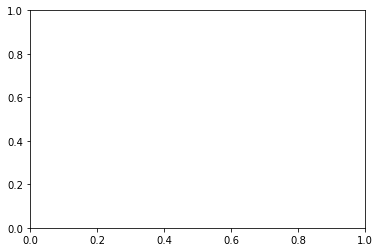

In [28]:
my_night_plot=sel_full_hourly_mean_ds.isel(hour=23).precipitation
map_proj = target_proj_p
my_night_plot.plot(ax=ax,transform=map_proj,  # the data's projection
                        cmap='Blues',
                        levels=6,alpha=0.7,
                        subplot_kws={'projection': map_proj},
                          robust=True
#                         size=8,
                       )  # the plot's projection)

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


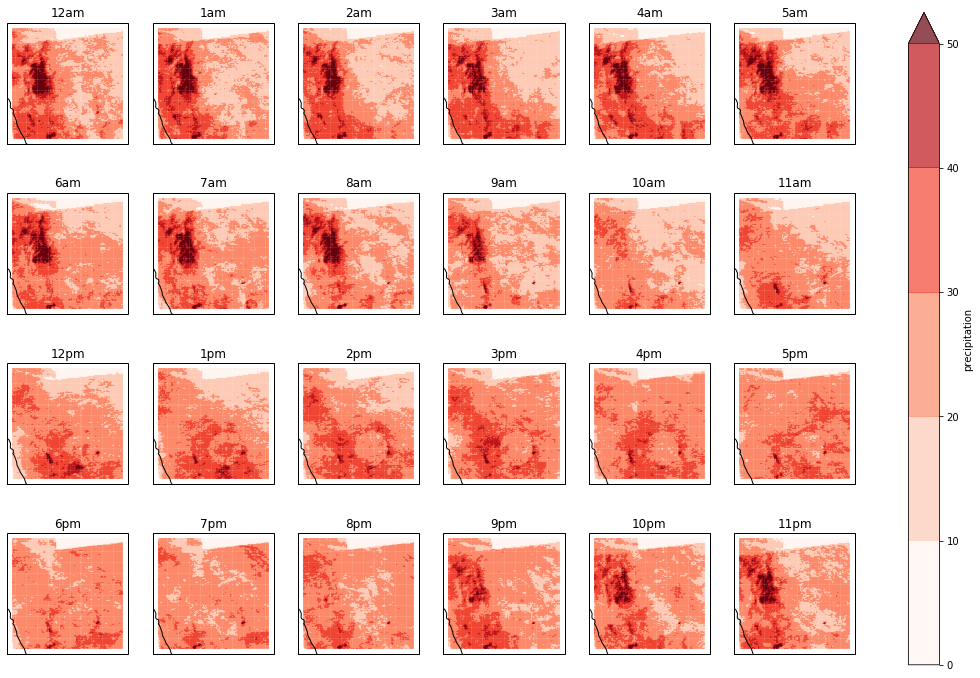

In [29]:
plt.close()
# Load the data
# ds = victas_month.precipitation
perth_hour_plot = sel_hourly_count_ds.isel(hour=[16,17,18,19,20,21,22,23,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]).precipitation
# T15_month_plot = T15_month.isel(month=[0,2,5,7,9,11]).precipitation

# This is the map projection we want to plot onto
map_proj = target_proj_p

p = perth_hour_plot.plot(transform=map_proj,  # the data's projection
                        col='hour', col_wrap=6,  # multiplot settings
                        cmap='Reds',
                        levels=6,alpha=0.7,
                        subplot_kws={'projection': map_proj},
                          robust=True
#                         size=8,
                       )  # the plot's projection

#oro = new_output_ds.plot.contourf(levels=6,cmap='gist_heat_r',linewidths=0.9,add_colorbar=True,ax=ax,add_labels=True,alpha=0.7)

# We have to set the map's options on all four axes
i=0
my_titles=['12am','1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm']
for ax in p.axes.flat:
    ax.coastlines('10m')
#     sel_full_hourly_mean_ds.sel(hour=0).plot(levels=6,cmap='gist_heat_r',linewidths=0.9,add_colorbar=True,ax=ax,add_labels=True,alpha=0.7)
#     ax.set_extent([-160, -30, 5, 75])
#     ax.set_aspect('equal', 'box-forced')
    ax.set_title(my_titles[i])
    i=i+1
plt.show()

## Scatter plot hour

In [30]:
#calculate mean precipitation per elevation bins
elevation_bins=np.append(-1000, np.arange(0, 1600, 50))
label_bins=np.append([0], np.arange(25,1550, 50))

In [31]:
sel_full_hourly_mean_ds_bin = sel_full_hourly_mean_ds.groupby_bins("dem",elevation_bins,labels=label_bins).mean(dim=['stacked_y_x']).precipitation

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/core.py:3924: PerformanceWarning: Increasing number of chunks by factor of 10
  **blockwise_kwargs,


In [32]:
sel_full_hourly_mean_ds_bin

<xarray.DataArray 'precipitation' (dem_bins: 32, hour: 24)>
dask.array<where, shape=(32, 24), dtype=float32, chunksize=(22, 1), chunktype=numpy.ndarray>
Coordinates:
  * dem_bins  (dem_bins) int64 0 25 75 125 175 225 ... 1325 1375 1425 1475 1525
  * hour      (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [33]:
sel_full_hourly_mean_ds.precipitation

<xarray.DataArray 'precipitation' (hour: 24, y: 100, x: 100)>
dask.array<getitem, shape=(24, 100, 100), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -3.451e+06 -3.449e+06 ... -3.255e+06 -3.253e+06
  * x        (x) float64 -1.611e+06 -1.609e+06 ... -1.415e+06 -1.413e+06
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [34]:
range(24)

range(0, 24)

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


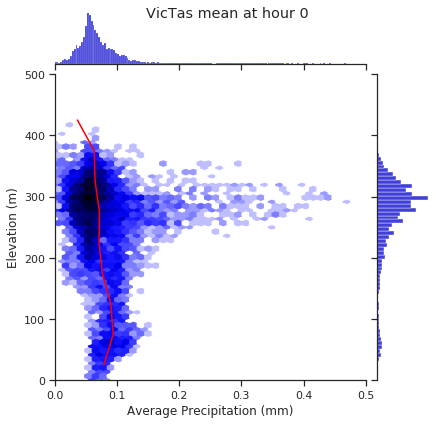

In [35]:
import seaborn as sns
sns.set_theme(style="ticks")

y = sel_full_hourly_mean_ds.sel(hour=0).dem.data.ravel()
x = sel_full_hourly_mean_ds.sel(hour=0).precipitation.data.ravel()

plot = sns.jointplot(x=x, y=y, kind="hex", color="#0000CD",dropna=True,xlim=(0,0.5),ylim=(0,500),gridsize=(50,30),hue_norm=(0,10),bins='log')
plot.ax_joint.set_ylabel('Elevation (m)')
plot.ax_joint.set_xlabel('Average Precipitation (mm)')
plot.ax_joint.plot(sel_full_hourly_mean_ds_bin.sel(hour=0),sel_full_hourly_mean_ds_bin.sel(hour=0).dem_bins,color='red')
plot.fig.suptitle('VicTas mean at hour '+str(0))

plt.show()

In [36]:
#plt.plot(sel_full_hourly_mean_ds_bin.sel(hour=h),sel_full_hourly_mean_ds_bin.sel(hour=h).dem_bins,color='red')

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


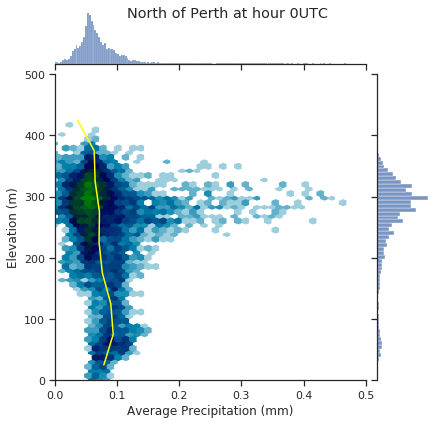

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


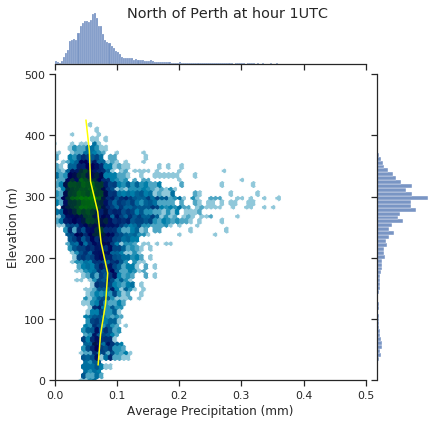

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


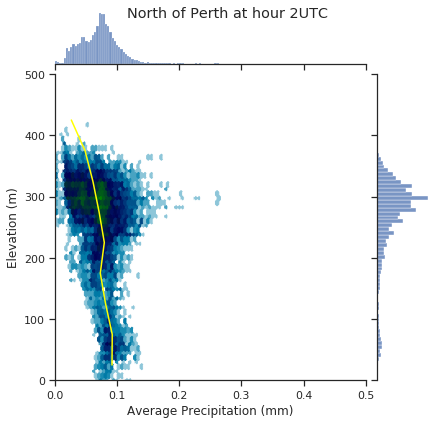

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


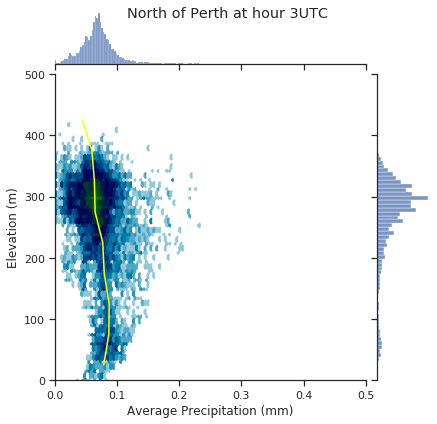

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


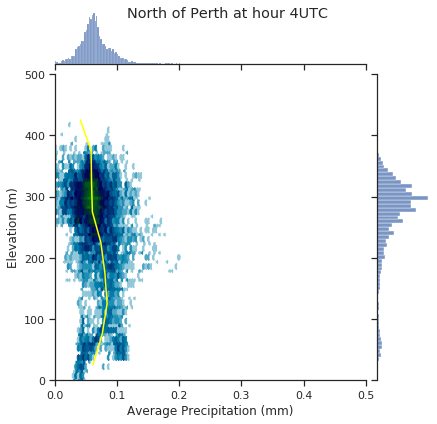

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


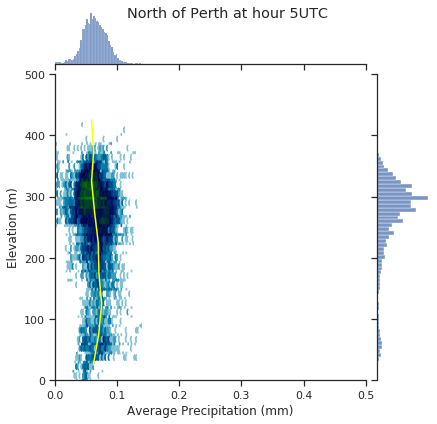

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


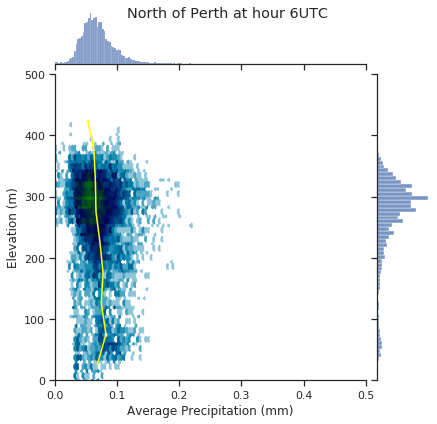

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


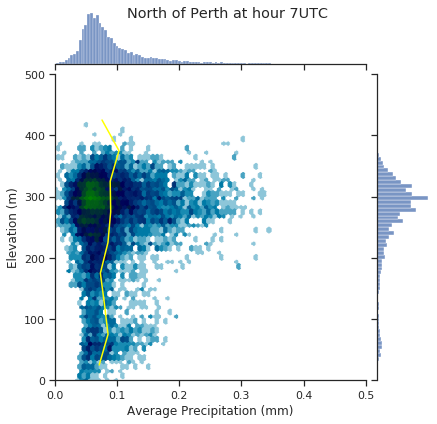

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


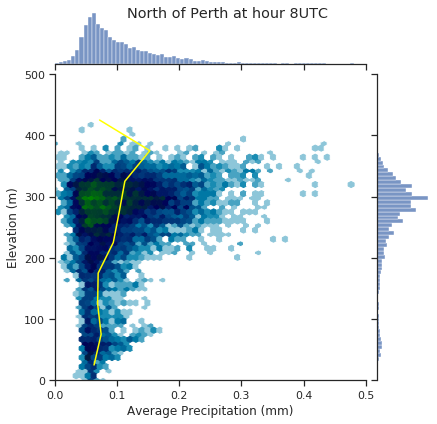

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


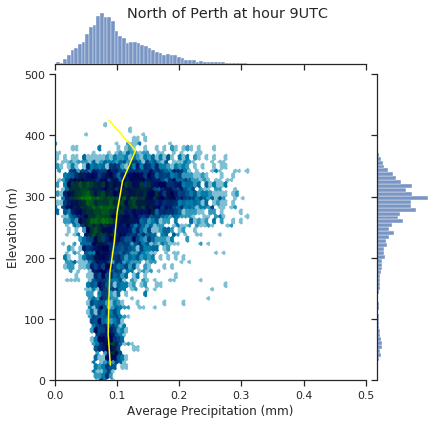

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


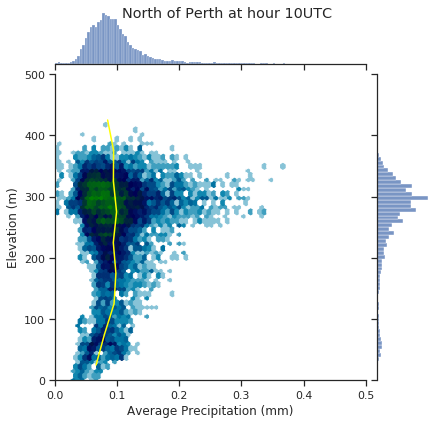

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


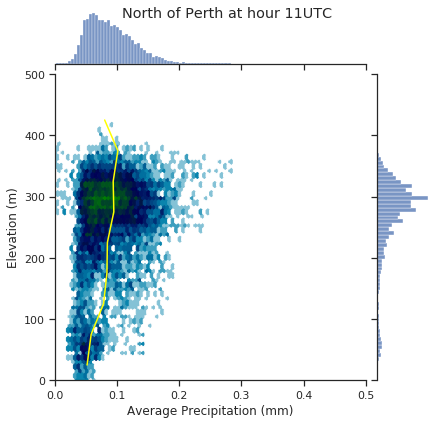

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


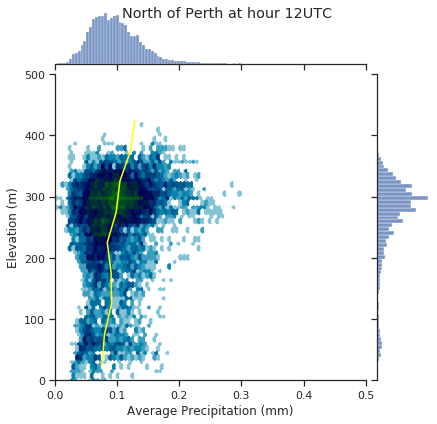

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


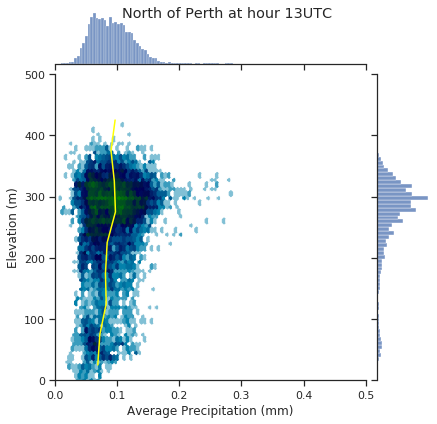

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


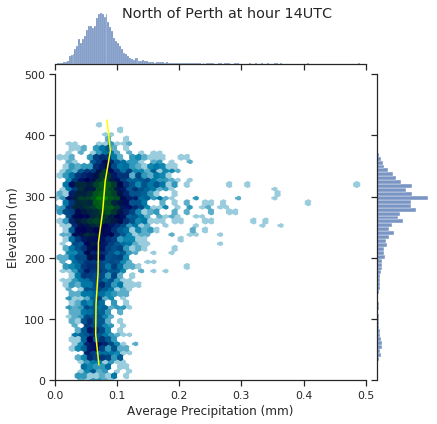

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


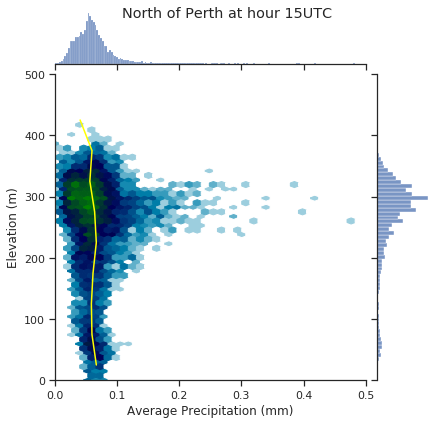

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


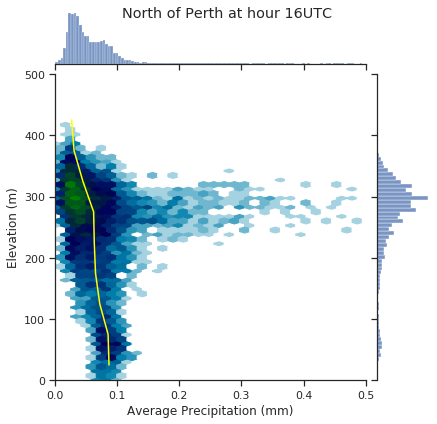

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


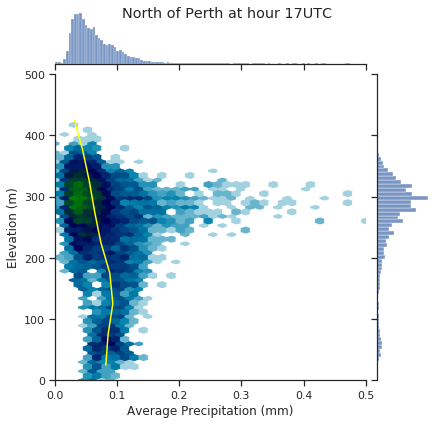

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


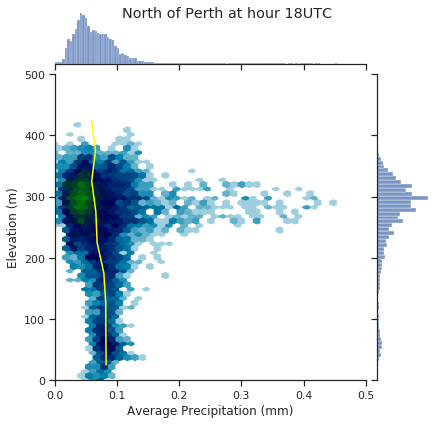

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


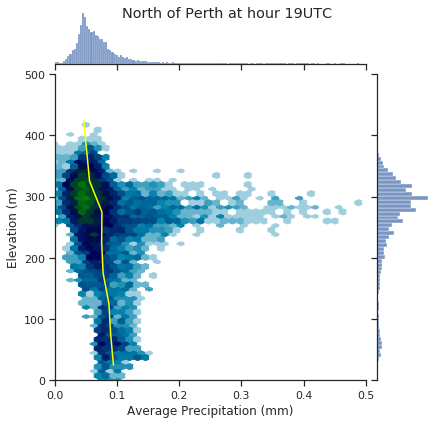

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


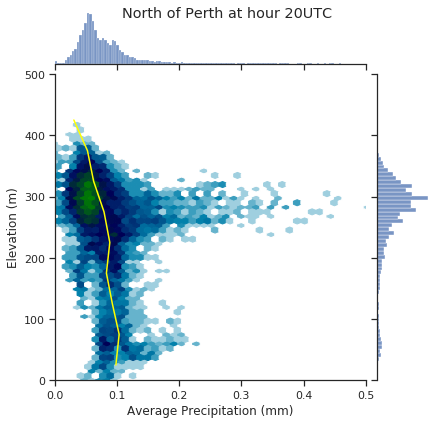

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


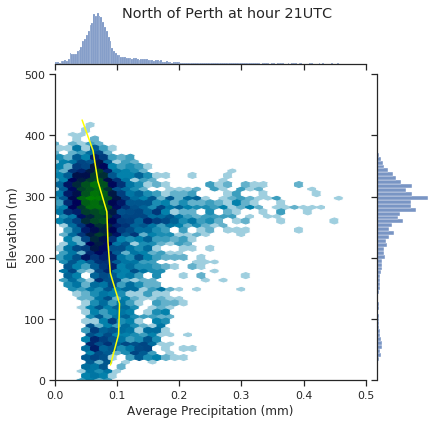

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


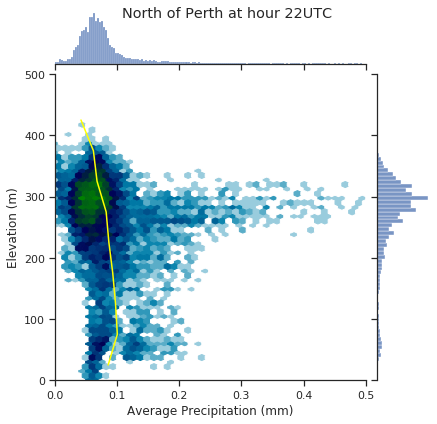

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


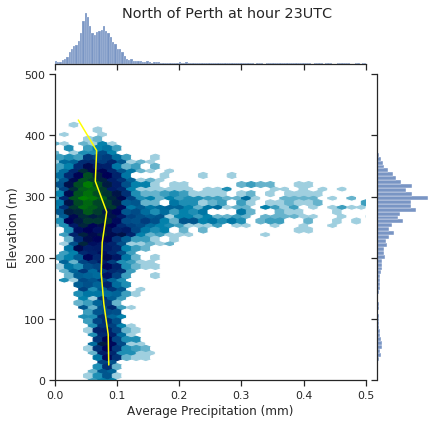

In [37]:
import seaborn as sns
for h in range(24):
    sns.set_theme(style="ticks")

    y = sel_full_hourly_mean_ds.sel(hour=h).dem.data.ravel()
    x = sel_full_hourly_mean_ds.sel(hour=h).precipitation.data.ravel()

    plot = sns.jointplot(x=x, y=y, kind="hex", cmap='ocean_r',dropna=True,xlim=(0,0.5),ylim=(0,500),hue_norm=(0,10),bins='log')
    plot.ax_joint.set_ylabel('Elevation (m)')
    plot.ax_joint.set_xlabel('Average Precipitation (mm)')
    plot.ax_joint.plot(sel_full_hourly_mean_ds_bin.sel(hour=h),sel_full_hourly_mean_ds_bin.sel(hour=h).dem_bins,color='yellow')
    plot.fig.suptitle('North of Perth at hour '+str(h)+'UTC')

    plt.show()

In [ ]:
# d = {}
# for i in range(len(hour_times)):
#     d['victas_count'+hour_times[i]]=xr.open_dataset("/home/565/dm2042/WIL/Frequency-data/victas_count-hour"+hour_times[i]+".nc")

In [70]:
# d['victas_count0']==victas_count0

In [71]:
# frames = [d['victas_count0'], d['victas_count1'], d['victas_count2'], d['victas_count3'], d['victas_count4'], d['victas_count5'], 
#           d['victas_count6'], d['victas_count7'], d['victas_count8'], d['victas_count9'], d['victas_count10'], d['victas_count11'], 
#           d['victas_count12'], d['victas_count13'], d['victas_count14'], d['victas_count15'], d['victas_count16'], d['victas_count17'], 
#           d['victas_count18'], d['victas_count19'], d['victas_count20'], d['victas_count21'], d['victas_count22'], d['victas_count23']
#          ]

In [72]:
#victas_count = pd.concat(frames)#, keys=hour_times)

In [73]:
# float('vic'+hour_times[0])

In [74]:
# perth_count0=xr.open_dataset("/home/565/dm2042/WIL/Frequency-data/perth_count-hour0.nc")
# perth_count0